<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/john210808/covasim_delta/blob/main/demo/week2/process.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
pip install covasim

Note: you may need to restart the kernel to use updated packages.


# 1. get data

In [2]:
import pandas as pd
from datetime import datetime

pd.read_csv("https://raw.githubusercontent.com/M3IT/COVID-19_Data/master/Data/COVID_AU_state.csv").to_csv("COVID_AU_state.csv")

def processDate(start_date):
    df = pd.read_csv("COVID_AU_state.csv")
    df['date'] = pd.to_datetime(df['date'])  
    mask = (df.date >= pd.to_datetime(start_date)) & (df.state_abbrev == 'NSW')
    df = df.loc[mask]
    initCase = df['confirmed_cum'].values[0]
    df = df[['date', 'confirmed', 'tests', 'deaths']]
    df.columns = ['date', 'new_diagnoses', 'new_tests', 'new_deaths']
    df.to_csv("nsw.csv", index=False)
    return initCase


# 2. simulate

5045
Covasim 3.0.7 (2021-06-29) — © 2021 by IDM


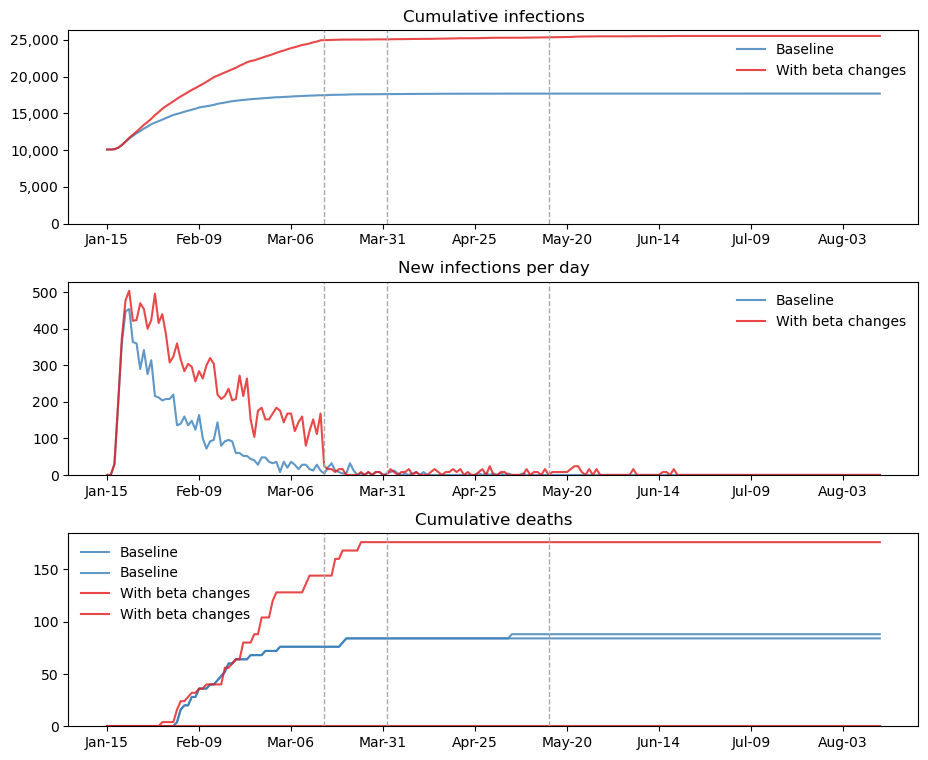

In [3]:
start_date='2021-01-15'
end_date = datetime.today().strftime('%Y-%m-%d') #'2021-09-15'
init = processDate(start_date)

print(init)

import covasim as cv
cv.options.set(dpi=100, show=True, close=False, verbose=0) # Standard options for Jupyter notebook
pars = dict(
    location = 'Australia', 
    pop_type  = 'hybrid',
    pop_size  = 81.66e3, # 8.166M people
    pop_scale = 100,
    pop_infected = init, 
    rescale   = True,
    rescale_threshold = 0.05,
    rescale_factor = 2,
    start_day = start_date,
    end_day   = end_date,
    
    beta      = 0.005,
)

orig_sim = cv.Sim(pars=pars, datafile='nsw.csv', interventions=cv.test_num(daily_tests='data'), label='Baseline')
# orig_sim.run()
# orig_sim.plot(to_plot=['cum_tests', 'cum_diagnoses', 'cum_deaths']);


# Define sim with change_beta
cb = cv.change_beta(days=['2021-03-15', '2021-04-01', '2021-05-15'], changes=[0.2, 1.5, 0.7], do_plot=True)
close_schools = cv.change_beta(days='2021-02-01', changes=0.1, layers='s')
tp = cv.test_prob(symp_prob=0.2, asymp_prob=0.001, symp_quar_prob=1.0, asymp_quar_prob=1.0, do_plot=False)
ct = cv.contact_tracing(trace_probs=dict(h=1.0, s=0.5, w=0.5, c=0.3), do_plot=False)

# Define the vaccine subtargeting
def vaccinate_by_age(sim):
    young  = cv.true(sim.people.age < 50) # cv.true() returns indices of people matching this condition, i.e. people under 50
    middle = cv.true((sim.people.age >= 50) * (sim.people.age < 75)) # Multiplication means "and" here
    old    = cv.true(sim.people.age > 75)
    inds = sim.people.uid # Everyone in the population -- equivalent to np.arange(len(sim.people))
    vals = np.ones(len(sim.people)) # Create the array
    vals[young] = 0.1 # 10% probability for people <50
    vals[middle] = 0.5 # 50% probability for people 50-75
    vals[old] = 0.9 # 90% probability for people >75
    output = dict(inds=inds, vals=vals)
    return output

sim = cv.Sim(pars, interventions=cb, label='With beta changes')

# Run and plot
msim = cv.MultiSim([orig_sim, sim])
msim.run()
msim.plot();

# 3. Interventions

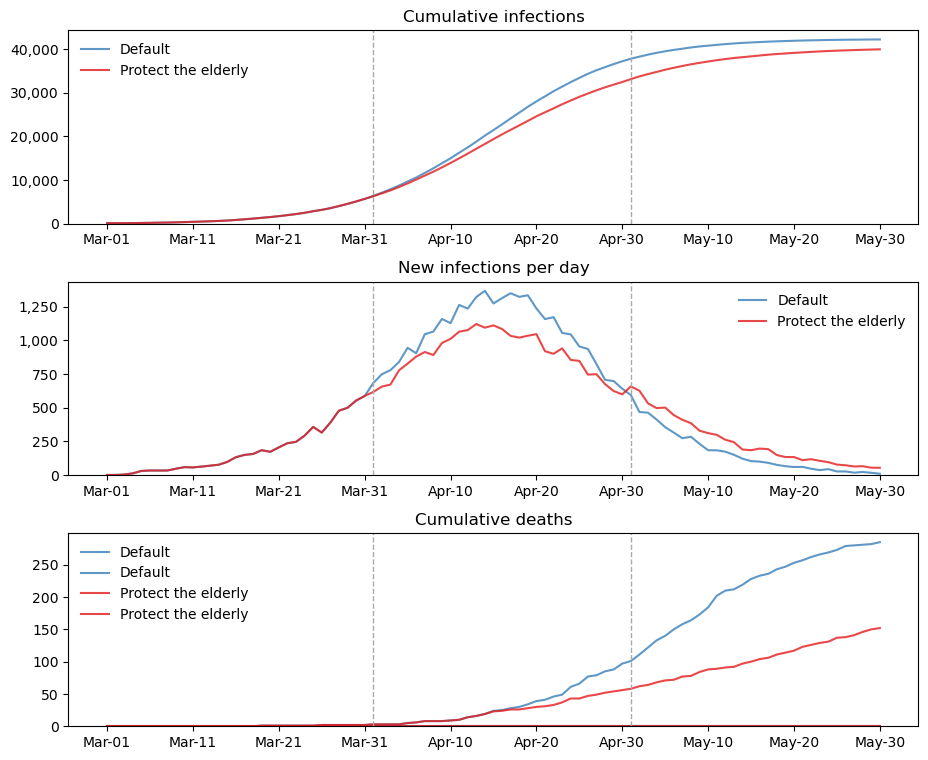

In [4]:
import numpy as np
import pylab as pl
import covasim as cv

class protect_elderly(cv.Intervention):

    def __init__(self, start_day=None, end_day=None, age_cutoff=70, rel_sus=0.0, *args, **kwargs):
        super().__init__(**kwargs) # NB: This line must be included
        self.start_day   = start_day
        self.end_day     = end_day
        self.age_cutoff  = age_cutoff
        self.rel_sus     = rel_sus
        return

    def initialize(self, sim):
        super().initialize() # NB: This line must also be included
        self.start_day   = sim.day(self.start_day) # Convert string or dateobject dates into an integer number of days
        self.end_day     = sim.day(self.end_day)
        self.days        = [self.start_day, self.end_day]
        self.elderly     = sim.people.age > self.age_cutoff # Find the elderly people here
        self.exposed     = np.zeros(sim.npts) # Initialize results
        self.tvec        = sim.tvec # Copy the time vector into this intervention
        return

    def apply(self, sim):
        self.exposed[sim.t] = sim.people.exposed[self.elderly].sum()

        # Start the intervention
        if sim.t == self.start_day:
            sim.people.rel_sus[self.elderly] = self.rel_sus

        # End the intervention
        elif sim.t == self.end_day:
            sim.people.rel_sus[self.elderly] = 1.0

        return

    def plot(self):
        pl.figure()
        pl.plot(self.tvec, self.exposed)
        pl.xlabel('Day')
        pl.ylabel('Number infected')
        pl.title('Number of elderly people with active COVID')
        return
    
# Define and run the baseline simulation
pars = dict(
    pop_size = 50e3,
    pop_infected = 100,
    n_days = 90,
    verbose = 0,
)
orig_sim = cv.Sim(pars, label='Default')

# Define the intervention and the scenario sim
protect = protect_elderly(start_day='2020-04-01', end_day='2020-05-01', rel_sus=0.1) # Create intervention
sim = cv.Sim(pars, interventions=protect, label='Protect the elderly')

# Run and plot
msim = cv.MultiSim([orig_sim, sim])
msim.run()
msim.plot();

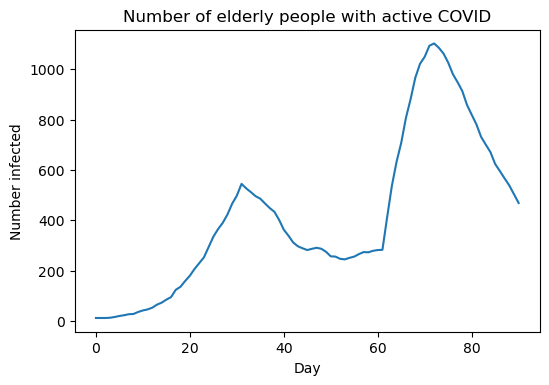

In [5]:
# Plot intervention
protect = msim.sims[1].get_intervention(protect_elderly) # Find intervention by type
protect.plot()

In [6]:
#https://forecast.id.com.au/sydney/population-age-structure?Year1=2016&Year2=2021&Year3=2041
AU_Sydney = {
'0-5'  : 3.6,
'5-9'  : 2.0,
'10-14': 1.6,
'15-19': 5.9,
'20-24': 14.2,
'25-29': 16.9,
'30-34': 14.1,
'35-39': 9.3,
'40-44': 6.4,
'45-49': 5.2,
'50-54': 4.6,
'55-59': 4.1,
'60-64': 3.5,
'65-69': 2.9,
'70-74': 2.3,
'75-79': 1.5,
'80-84': 1.0,
'85+'  : 0.9}

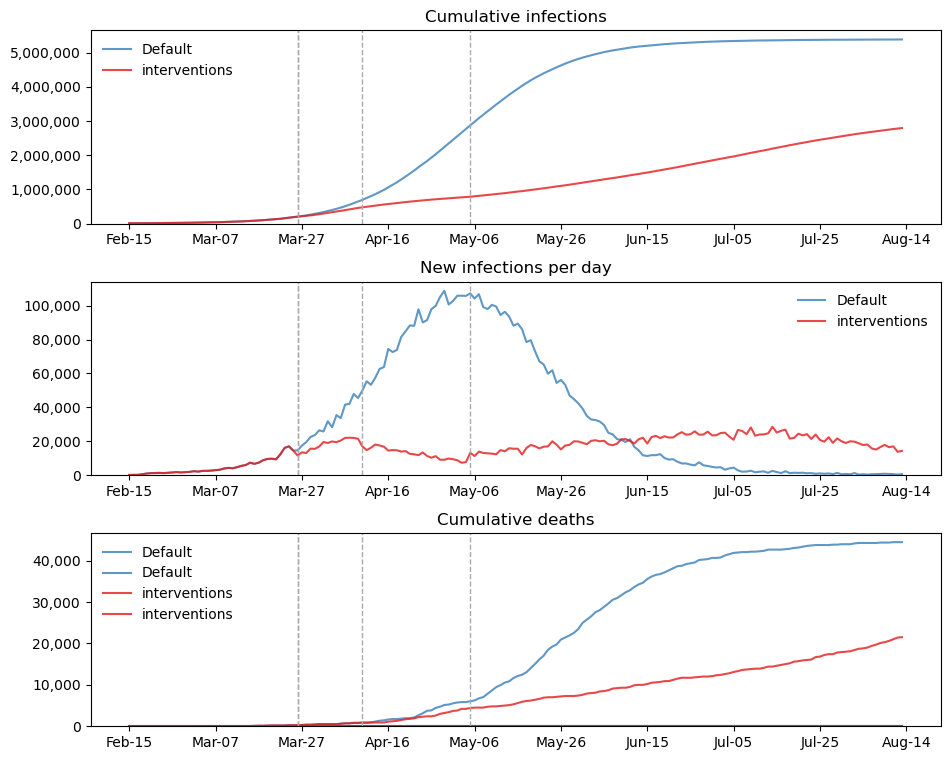

In [7]:
start_date='2021-02-15'
end_date = datetime.today().strftime('%Y-%m-%d') #'2021-09-15'

tr_probs = dict(h=0.9, s=0.7, w=0.7, c=0.3)
tr_time = dict(h=0.0, s=1.0, w=1.0, c=3.0)
m_days = ['2021-03-26', '2021-04-10', '2021-05-05']
m_changes = [0.7, 0.4, 0.8]
pars = dict(
    location = 'Australia', 
    pop_type  = 'hybrid',
    pop_size  = 81.66e3, # 8.166M people
    pop_scale = 100,
    pop_infected = init, 
    rescale   = True,
    rescale_threshold = 0.05,
    rescale_factor = 2,
    start_day = start_date,
    end_day   = end_date,
    
    beta      = 0.012,
)

interventions = [
    cv.clip_edges(days='2021-03-26', changes=0.0, layers='s', do_plot=True), # close schools
    cv.clip_edges(days=m_days, changes=m_changes, layers=['w', 'c'], do_plot=True), # close/reopen work + community
]

sim1 = cv.Sim(pars=pars, label='Default')
sim2 = cv.Sim(pars=pars, interventions=interventions, label='interventions')
msim = cv.MultiSim([sim1, sim2])
msim.run(n_runs=1)
# msim.mean()
msim.plot();


# 4. Calibration

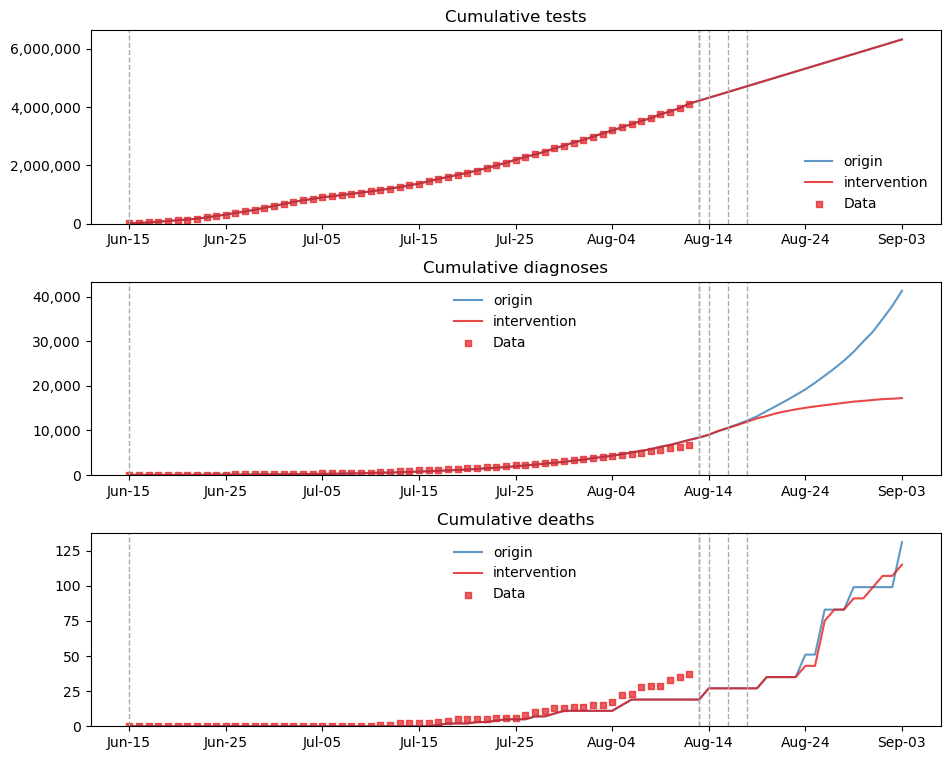

In [13]:
from datetime import timedelta, datetime

def dayShift(d):
    return (datetime.today() + timedelta(d)).strftime("%Y-%m-%d")
start_date='2021-06-15'
end_date = dayShift(21) # '2021-09-15' 
today = datetime.today().strftime("%Y-%m-%d")
init = processDate(start_date)

# Parameters
pars = dict(
    location = 'Australia', 
    pop_type  = 'hybrid',
    pop_size  = 81.66e3, # 8.166M people
    pop_scale = 100,
    pop_infected = init * 0.01, 
    rescale   = True,
    rescale_threshold = 0.05,
    rescale_factor = 2,
    start_day = start_date,
    end_day   = end_date,
    beta      = 0.023,
)

# Interventions
tn_data = cv.test_num('data')  # actural data from csv
tn_fixed = cv.test_num(daily_tests=100000, start_day=today)  # daliy test
tp = cv.test_prob(symp_prob=0.2, asymp_prob=0.001, symp_quar_prob=1.0, asymp_quar_prob=1.0, do_plot=False)
ct = cv.contact_tracing(start_day=today, trace_probs=dict(h=1.0, s=0.5, w=0.5, c=0.3), do_plot=False)

interventions = [ # intervension using just fixed daliy test after today
    tn_data,
    tn_fixed
]
sim1 = cv.Sim(pars=pars, datafile="nsw.csv", interventions=interventions, label='origin')

interventions2 = [  
    cv.clip_edges(days=today, changes=0.0, layers='s', do_plot=True), # close schools
    cv.clip_edges(days=[dayShift(1), dayShift(3), dayShift(5)], 
                changes=[0.3, 0.3, 0.3], layers=['w', 'c'], do_plot=True), # close/reopen work + community
    tn_data,  # actual data from csv
    tn_fixed, # daliy test
    ct        # contact tracing
]
sim2 = cv.Sim(pars=pars, datafile="nsw.csv", interventions=interventions2, label='intervention')

# Run and plot
msim = cv.MultiSim([sim1, sim2])
msim.run(n_runs=1)
msim.plot(to_plot=['cum_tests', 'cum_diagnoses', 'cum_deaths']);

5623


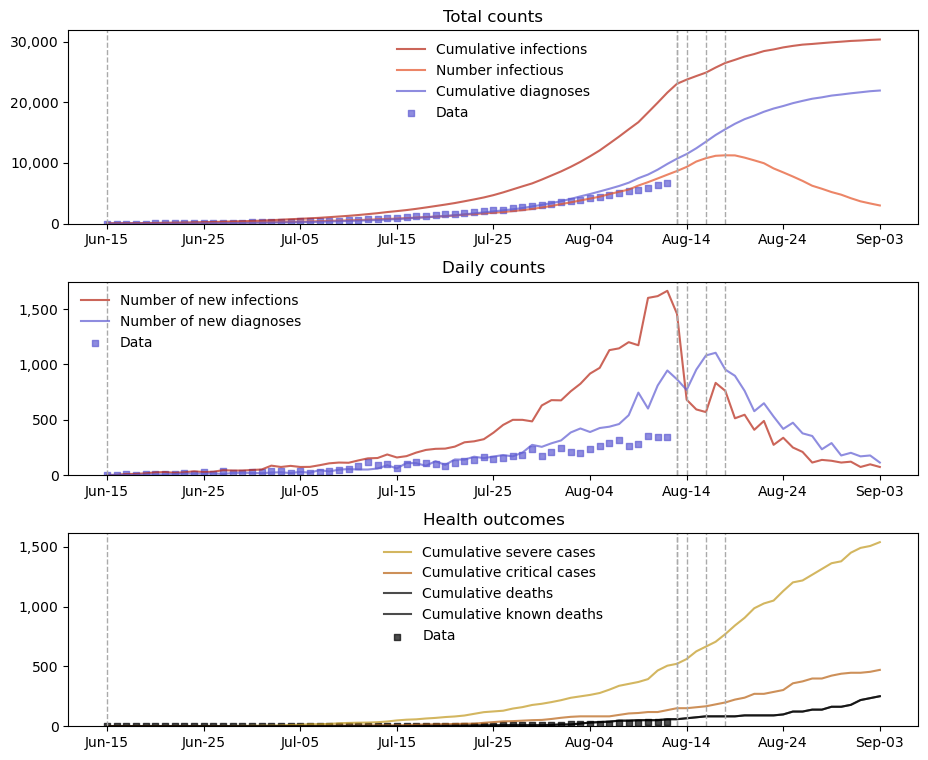

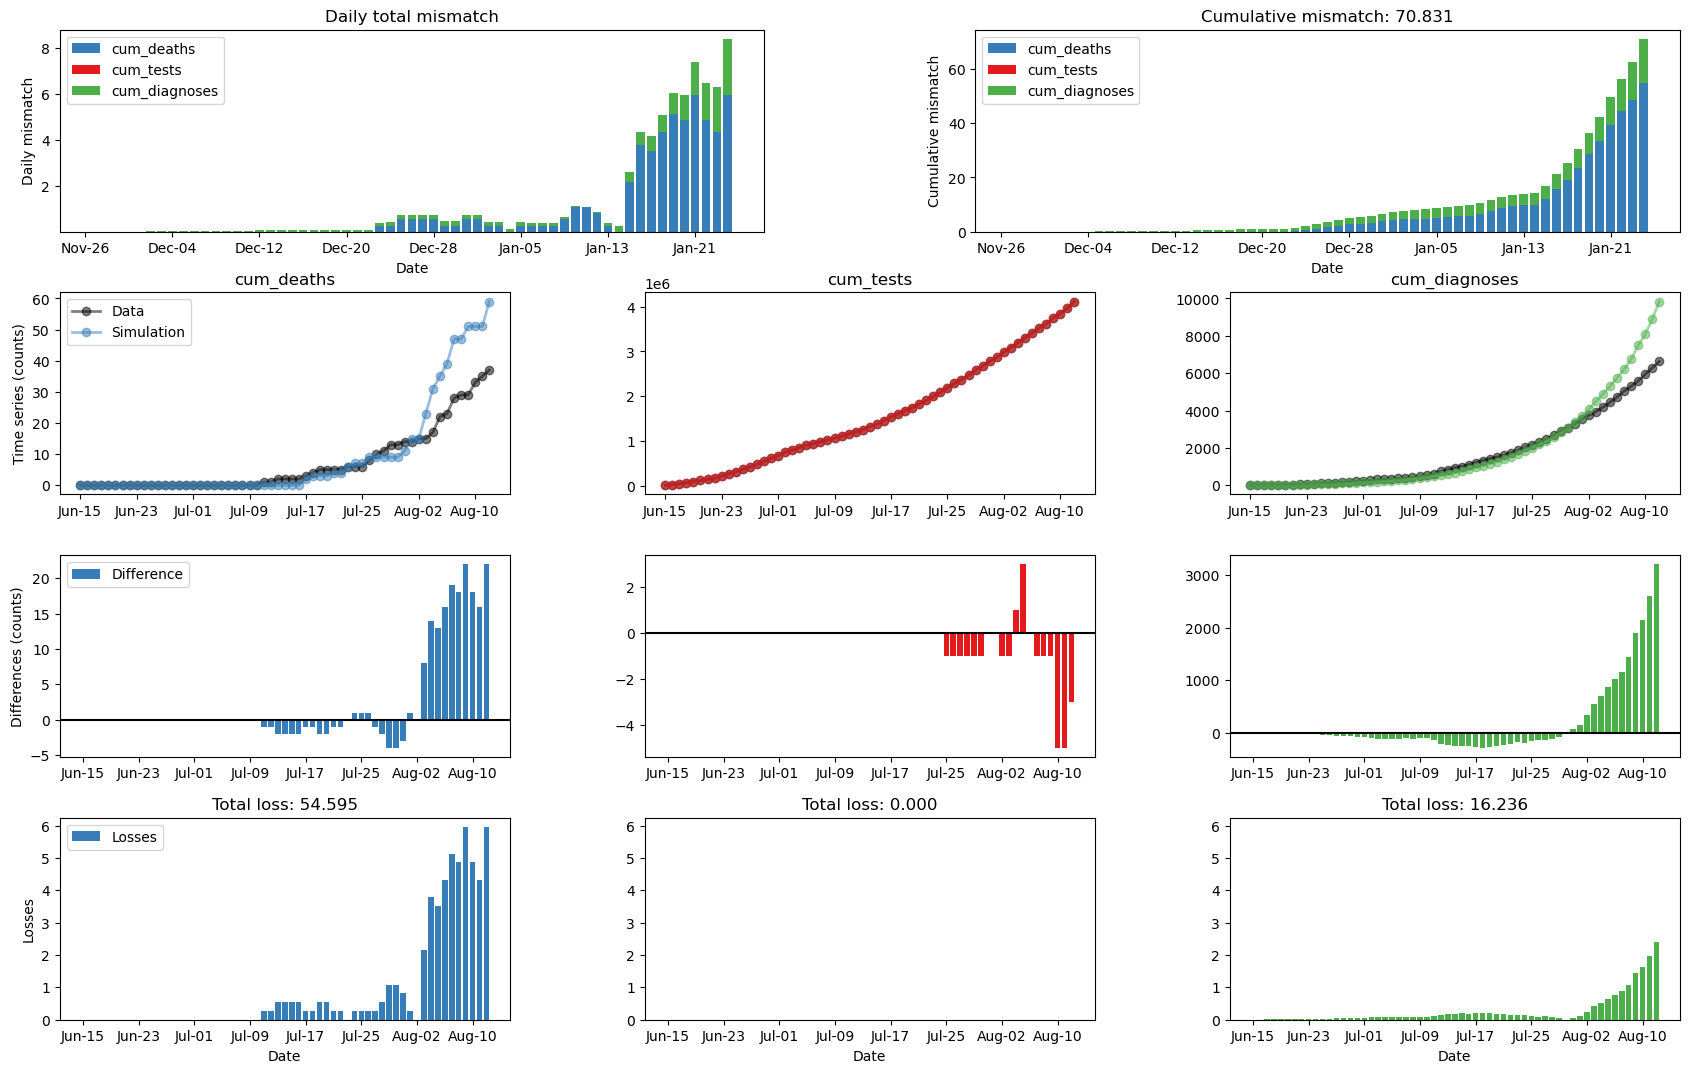

#0. cum_deaths:    54.59459459459459
#1. cum_tests:     6.801917946520405e-06
#2. cum_diagnoses: 16.23604826546003
70.83064966197257


In [9]:
from datetime import timedelta, datetime

def dayShift(d):
    return (datetime.today() + timedelta(d)).strftime("%Y-%m-%d")

start_date='2021-06-15'
end_date = dayShift(21) # '2021-09-15' 
today = datetime.today().strftime("%Y-%m-%d")

init = processDate(start_date)

print(init)

pars = dict(
    location = 'Australia', 
    pop_type  = 'hybrid',
    pop_size  = 81.66e3, # 8.166M people
    pop_scale = 100,
    pop_infected = init * 0.01, 
    rescale   = True,
    rescale_threshold = 0.05,
    rescale_factor = 2,
    start_day = start_date,
    end_day   = end_date,
    
    beta      = 0.023,
)

# Define the testing interventions
tn_data = cv.test_num('data')
tn_fixed = cv.test_num(daily_tests=100000, start_day=today)
# tp = cv.test_prob(symp_prob=0.2, asymp_prob=0.001, start_day=today)

# Define the testing and contact tracing interventions
tp = cv.test_prob(symp_prob=0.2, asymp_prob=0.001, symp_quar_prob=1.0, asymp_quar_prob=1.0, do_plot=False)
ct = cv.contact_tracing(start_day=today, trace_probs=dict(h=1.0, s=0.5, w=0.5, c=0.3), do_plot=False)


interventions = [
    cv.clip_edges(days=today, changes=0.0, layers='s', do_plot=True), # close schools
    cv.clip_edges(days=[dayShift(1), dayShift(3), dayShift(5)], 
                  changes=[0.3, 0.3, 0.3], layers=['w', 'c'], do_plot=True), # close/reopen work + community
    tn_data,
    tn_fixed,
    ct
]
sim = cv.Sim(pars=pars, datafile="nsw.csv", interventions=interventions, analyzers=cv.age_histogram(), label='intervention')

# Run and plot
sim.run()
# sim2.plot(to_plot=['cum_tests', 'cum_diagnoses', 'cum_deaths']);

sim['rel_death_prob'] = 2 # Double the death rate since deaths were too low
sim.initialize(reset=True) # Reinitialize the sim

# Rerun and compute fit
sim.run()
fit = sim.compute_fit()

# Output
sim.plot()
fit.plot()
print(fit.mismatches)
print(fit.mismatch)

[<Figure size 1200x800 with 5 Axes>]

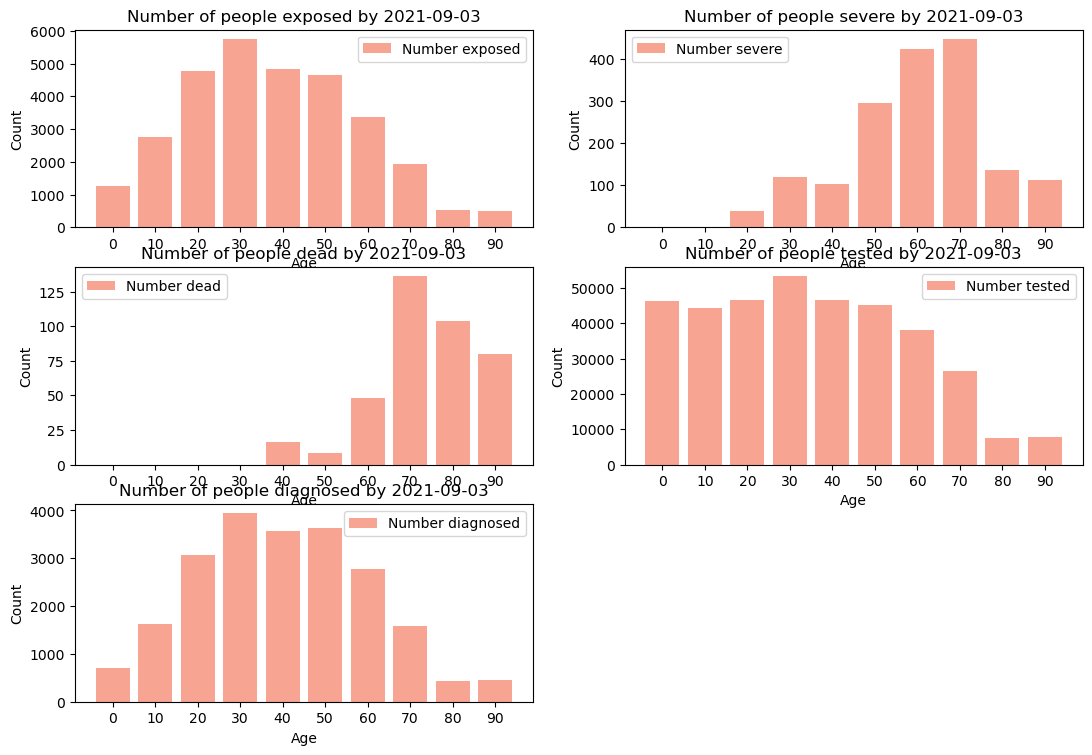

In [10]:
agehist = sim.get_analyzer() # Only one analyzer so we can retrieve it like this
agehist.plot()

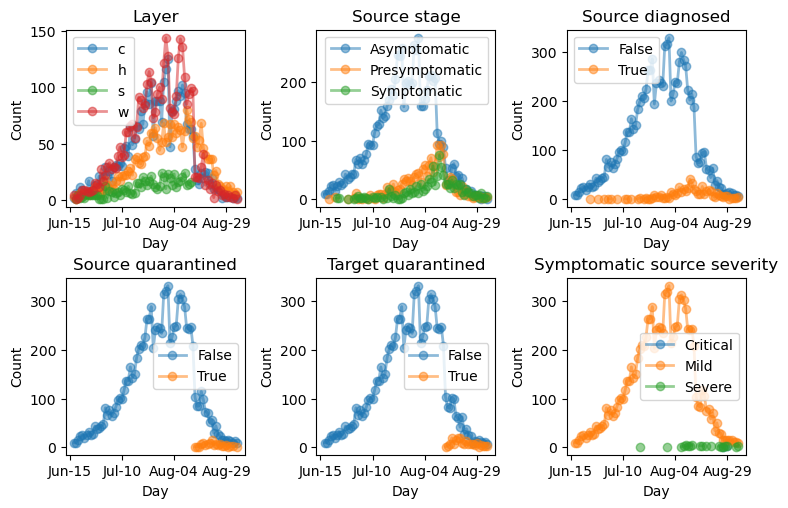

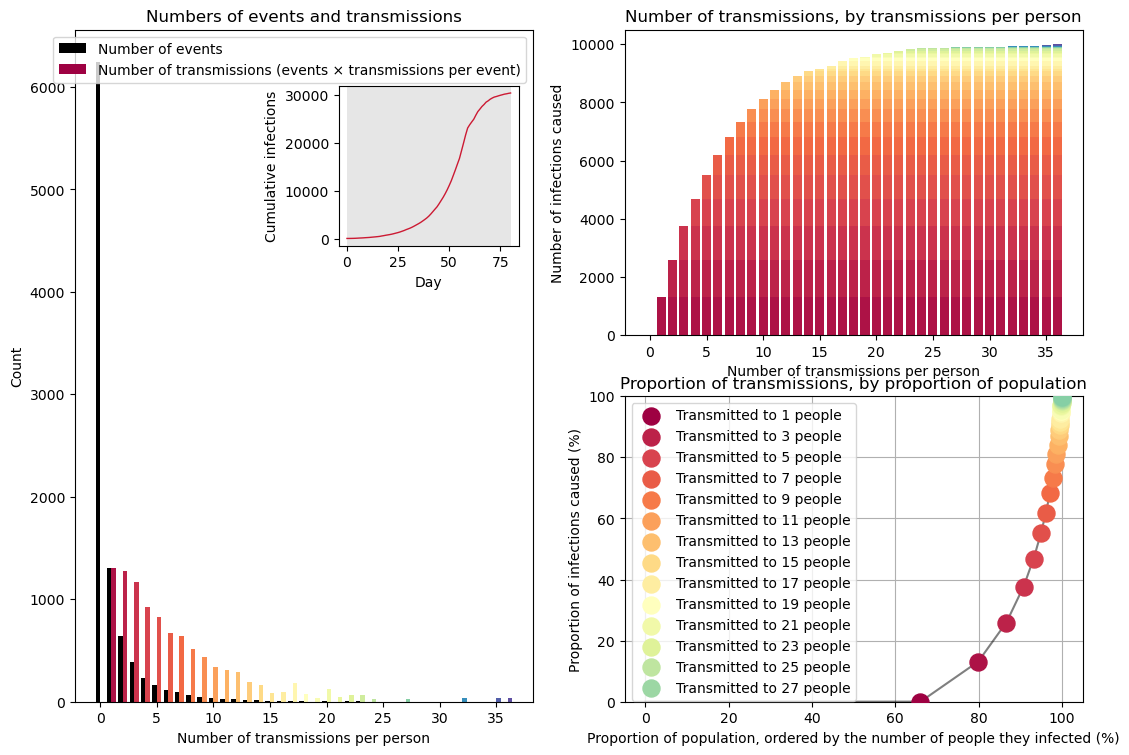

In [11]:
tt = sim.make_transtree()
fig1 = tt.plot()
fig2 = tt.plot_histograms()

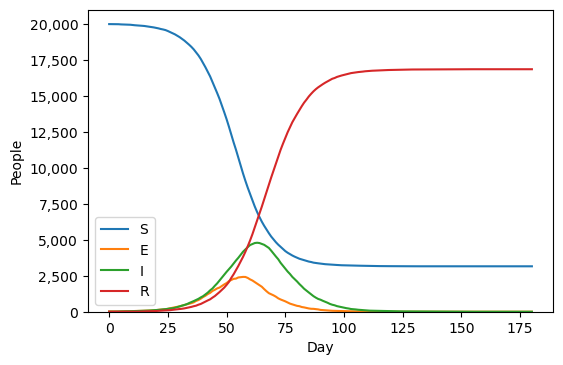

In [12]:
import pylab as pl
import sciris as sc
import covasim as cv

class store_seir(cv.Analyzer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs) # This is necessary to initialize the class properly
        self.t = []
        self.S = []
        self.E = []
        self.I = []
        self.R = []
        return

    def apply(self, sim):
        ppl = sim.people # Shorthand
        self.t.append(sim.t)
        self.S.append(ppl.susceptible.sum())
        self.E.append(ppl.exposed.sum() - ppl.infectious.sum())
        self.I.append(ppl.infectious.sum())
        self.R.append(ppl.recovered.sum() + ppl.dead.sum())
        return

    def plot(self):
        pl.figure()
        pl.plot(self.t, self.S, label='S')
        pl.plot(self.t, self.E, label='E')
        pl.plot(self.t, self.I, label='I')
        pl.plot(self.t, self.R, label='R')
        pl.legend()
        pl.xlabel('Day')
        pl.ylabel('People')
        sc.setylim() # Reset y-axis to start at 0
        sc.commaticks() # Use commas in the y-axis labels
        return

# sim = cv.Sim(pars=pars, datafile="nsw.csv", interventions=interventions, analyzers=store_seir(label='seir'), label='intervention')

sim = cv.Sim(n_days=180, analyzers=store_seir(label='seir'))
sim.run()
seir = sim.get_analyzer('seir') # Retrieve by label
seir.plot()